# 0.0. Imports

In [1]:
import random
import pandas as pd
import numpy  as np
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt

from keras import models as ml
from keras import layers as l

warnings.filterwarnings('ignore')

## 0.1. Auxiliar Functions

In [2]:
def cross_validation(num_fold, x_train, y_train, model, verbose=False):
    # generate k-fold
    num_folds = 5
    kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

    # create empty metrics list
    acc_list = []
    balanced_acc_list = []
    kappa_list = []

    # sequence of loop for verbose
    i = 1
    
    # interation to measure performance
    for train_index, val_index in kfold.split( x_train, ohe.inverse_transform(y_train) ):
        if verbose:
            print(f'Fold Number:{i}/{num_folds}')

        # split data into training and test set
        x_train_cv = x_train.iloc[train_index]
        y_train_cv = y_train.iloc[train_index]

        x_validation_cv = x_train.iloc[val_index]
        y_validation_cv = y_train.iloc[val_index]

        # train model
        model.fit(x_train_cv, y_train_cv, epochs=100, batch_size=32, verbose=0)

        # prediction
        pred_cv = model.predict(x_validation_cv)

        # invert prediction
        yhat_cv = ohe.inverse_transform(pred_cv)

        # invert validation response
        y_test_cv = ohe.inverse_transform(y_validation_cv)

        # performance metrics
        # Accuracy
        acc_nn = m.accuracy_score( y_test_cv, yhat_cv )
        acc_list.append(acc_nn)
        
        # Balanced Accuracy
        balanced_acc_nn = m.balanced_accuracy_score(y_test_cv, yhat_cv)
        balanced_acc_list.append(balanced_acc_nn)

        # Kappa Metrics
        kappa_nn = m.cohen_kappa_score(y_test_cv, yhat_cv)
        kappa_list.append(kappa_nn)

        i += 1

    return acc_list, balanced_acc_list, kappa_list

## 0.2. Load Data

In [3]:
# load training set of user
data_users = pd.read_csv('../Datasets/train_users_2.csv', low_memory=False)

# load web sessions log for users
data_sessions = pd.read_csv('../Datasets/sessions.csv', low_memory=False)

# 1.0. Data Description

In [4]:
df01_users = data_users.copy()

df01_sessions = data_sessions.copy()

## 1.1. Data Types

In [5]:
df01_users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [6]:
df01_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.2. Data Dimensions

### 1.2.1. Data Users Dimensions 

In [7]:
print( f'Number of rows of users dataset: {df01_users.shape[0]}')
print( f'Number of columnss of users dataset: {df01_users.shape[1]}')

Number of rows of users dataset: 213451
Number of columnss of users dataset: 16


### 1.2.2. Data Sessions Dimensions

This dataset will not be used in this first cycle due to the granularity being action and we want to be user_id for now.

In [8]:
print( f'Number of rows of sessions dataset: {df01_sessions.shape[0]}')
print( f'Number of columnss of session dataset: {df01_sessions.shape[1]}')

Number of rows of sessions dataset: 10567737
Number of columnss of session dataset: 6


## 1.3. Check NA

### 1.3.1. Check NA - Data Users

In [9]:
df01_users.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [10]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

### 1.3.2. Check NA - Data Sessions

In [11]:
df01_sessions.isna().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [12]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4. Fillout NA

### 1.4.1. Fillout NA - Data Users

- **date_first_booking:** the maximum date of the dataset is chosen due to future features considered the space between dates.

- **age:** variable age has a normal distribution, so replacing it with with a mean value will not bias the dataset.

- **first_affiliate_tracked:** due to the high probability of bias the dataset with categorical data substitution and the low amount of NA datas in this variable, the NA lines will be dropped.

In [13]:
# date_first_booking
max_date_first_booking = pd.to_datetime(df01_users['date_first_booking']).max().strftime('%Y-%m-%d')
df01_users['date_first_booking'] = df01_users['date_first_booking'].fillna(max_date_first_booking)

# age
avg_age = int(df01_users['age'].mean())
df01_users['age'] = df01_users['age'].fillna(avg_age)

# first_affiliate_tracked
df01_users = df01_users[~df01_users['first_affiliate_tracked'].isna()]

In [14]:
df01_users.isna().sum()/df01_users.shape[0]

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

### 1.4.2. Fillout NA - Data Sessions

Due to a massise amount of data, all NA lines will be dropped.

In [15]:
# user_id  - 0.003264
df01_sessions = df01_sessions[~df01_sessions['user_id'].isna()]

# action - 0.007535
df01_sessions = df01_sessions[~df01_sessions['action'].isna()]

# action_type - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_type'].isna()]

# action_detail - 0.106570
df01_sessions = df01_sessions[~df01_sessions['action_detail'].isna()]

# secs_elapsed - 0.012872
df01_sessions = df01_sessions[~df01_sessions['secs_elapsed'].isna()]

In [16]:
df01_sessions.isna().sum()/df01_sessions.shape[0]

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.5. Change Data Type

In [17]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
130363,8mzkyyk318,2013-12-06,20131206191940,2015-06-29,-unknown-,49.0,basic,0,en,sem-brand,google,untracked,Web,Mac Desktop,Chrome,NDF


In [18]:
# change date type
df01_users['date_account_created'] = pd.to_datetime(df01_users['date_account_created'])
df01_users['date_first_booking'] = pd.to_datetime(df01_users['date_first_booking'])

# change datetime type
df01_users['timestamp_first_active'] = pd.to_datetime(df01_users['timestamp_first_active'], format='%Y%m%d%H%M%S')

# change age to int
df01_users['age'] = df01_users['age'].astype(np.int64)

In [19]:
df01_users.sample(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
141714,hpyr44skxb,2014-01-14,2014-01-14 17:58:48,2015-06-29,MALE,33,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF


In [20]:
df01_users.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6. Check Balanced Data

Data with an unbalance of 70% for the US class.

In [21]:
df01_users['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

# 2.0. Feature Engineering

To increase time, no feature engineering will be done for this first cycle.

In [22]:
df02_users = df01_users.copy()

# 3.0. Data Filtering

To increase time, the Data Filtering stage will be skipped in this first cycle.

In [23]:
df03_users = df02_users.copy()

## 3.1. Filtering Rows

## 3.2. Columns Selection

In [24]:
df03_users = df03_users.drop(['id'], axis=1)

# 4.0. Data Exploratory Analysis

To increase time, the EDA stage will be skipped in this first cycle.

In [25]:
df04_users = df03_users.copy()

# 5.0. Data Preparation

In [26]:
df05_users = df04_users.copy()

## 5.1. Encoding

In [27]:
# dummy variable
df05_users_dummy = pd.get_dummies(df05_users.drop(['country_destination'], axis=1))

# join id and country destination
df05_users = pd.concat( [df05_users['country_destination'], df05_users_dummy], axis=1 )

## 5.2. Response Variable

In [28]:
# create OneHotEncoder instance
ohe = pp.OneHotEncoder()

# ohe hot encoding response feature
df_ohe = pd.DataFrame(ohe.fit_transform(df05_users['country_destination'].values.reshape(-1,1)).toarray(),
                      columns=ohe.categories_[0],
                      index=df05_users.index)

# joining encoded response feature to dataset
df05_users = pd.concat([df05_users.drop(columns=['country_destination']), df_ohe], axis=1)

# 6.0. Feature Selection

Original date will be discarded in this first cycle because data must first be derived from them, like years and months.

In [29]:
df06_users = df05_users.copy()

In [30]:
# droping original dates
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']
df06_users = df06_users.drop(cols_drop, axis=1)

## 6.1. Split Dataframe into Training and Test Dataset

In [31]:
# training dataset
X = df06_users.drop(columns=ohe.categories_[0])

# separate response dataset
y = df06_users[ohe.categories_[0]]

In [32]:
# Split dataset into training and test (validation)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# 7.0. Machine Learing Model

In [33]:
x_train = X_train
x_test = X_test

## 7.1. Baseline Model - Random

In [34]:
# list of country destination
country_list = ohe.categories_[0].tolist()

# number of rows
k_num = y_test.shape[0]

# proportion of country destinations for imbalanced result
df_ohe = pd.DataFrame(ohe.inverse_transform(df06_users[ohe.categories_[0]]))
country_weights = df_ohe.value_counts(normalize=True).sort_index().tolist()

# prediction
yhat_random = random.choices(population=country_list,
                             weights=country_weights,
                             k=k_num)

# invert validation response
y_test_random = ohe.inverse_transform(y_test)

### 7.1.1. Baseline Model - Performance

Accuracy 0.4254303486185448
Balanced Accuracy: 0.08224520777838834
Kappa Score: 0.0008103433195443266
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       111
          CA       0.00      0.00      0.00       281
          DE       0.00      0.00      0.00       215
          ES       0.01      0.01      0.01       428
          FR       0.02      0.02      0.02      1021
          GB       0.02      0.02      0.02       426
          IT       0.01      0.01      0.01       570
         NDF       0.58      0.58      0.58     23996
          NL       0.00      0.00      0.00       146
          PT       0.00      0.00      0.00        48
          US       0.29      0.29      0.29     12280
       other       0.04      0.05      0.05      1956

    accuracy                           0.43     41478
   macro avg       0.08      0.08      0.08     41478
weighted avg       0.43      0.43      0.43     41478



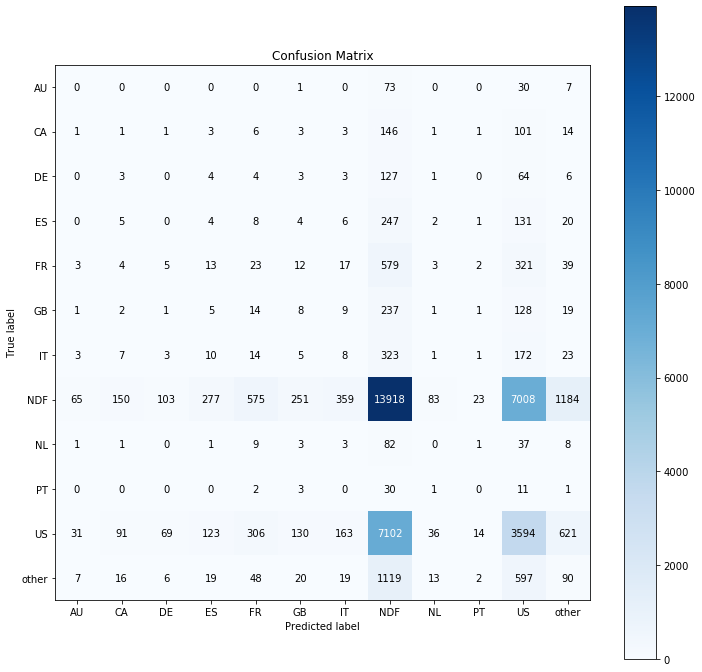

In [35]:
# Accuracy
acc_random = m.accuracy_score( y_test_random, yhat_random )
print(f'Accuracy {acc_random}')

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test_random, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test_random, yhat_random)
print(f'Kappa Score: {kappa_random}')

# Classification report
print(m.classification_report(y_test_random, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_random, yhat_random, normalize=False, figsize=(12,12));

# Performance
baseline_performance = {'model': 'Baseline Model', 
                        'acc': acc_random, 
                        'balanced_acc': balanced_acc_random, 
                        'kappa_score': kappa_random}

## 7.2. Neural Network - MLP

In [36]:
# model definition
model_nn = ml.Sequential()
model_nn.add( l.Dense(128, input_dim=x_train.shape[1], activation='relu') )
model_nn.add( l.Dense(12, activation='softmax') )

# model compile
model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model_nn.fit(x_train, y_train, epochs=100)

Epoch 1/100
5185/5185 [==============================] - 7s 1ms/step - loss: 1.2586 - accuracy: 0.5868
Epoch 2/100
5185/5185 [==============================] - 6s 1ms/step - loss: 1.1594 - accuracy: 0.6031
Epoch 3/100
5185/5185 [==============================] - 6s 1ms/step - loss: 1.1271 - accuracy: 0.6125
Epoch 4/100
5185/5185 [==============================] - 5s 1ms/step - loss: 1.1063 - accuracy: 0.6152
Epoch 5/100
5185/5185 [==============================] - 7s 1ms/step - loss: 1.0960 - accuracy: 0.6191
Epoch 6/100
5185/5185 [==============================] - 5s 1ms/step - loss: 1.0896 - accuracy: 0.6197
Epoch 7/100
5185/5185 [==============================] - 6s 1ms/step - loss: 1.0871 - accuracy: 0.6201
Epoch 8/100
5185/5185 [==============================] - 6s 1ms/step - loss: 1.0854 - accuracy: 0.6204
Epoch 9/100
5185/5185 [==============================] - 6s 1ms/step - loss: 1.0849 - accuracy: 0.6217
Epoch 10/100
5185/5185 [==============================] - 8s 2ms/step - l

5185/5185 [==============================] - 5s 1ms/step - loss: 1.0704 - accuracy: 0.6258
Epoch 76/100
5185/5185 [==============================] - 6s 1ms/step - loss: 1.0704 - accuracy: 0.6255
Epoch 77/100
5185/5185 [==============================] - 6s 1ms/step - loss: 1.0702 - accuracy: 0.6255
Epoch 78/100
5185/5185 [==============================] - 5s 1ms/step - loss: 1.0706 - accuracy: 0.6258
Epoch 79/100
5185/5185 [==============================] - 6s 1ms/step - loss: 1.0694 - accuracy: 0.6255
Epoch 80/100
5185/5185 [==============================] - 6s 1ms/step - loss: 1.0696 - accuracy: 0.6255
Epoch 81/100
5185/5185 [==============================] - 5s 1ms/step - loss: 1.0698 - accuracy: 0.6253
Epoch 82/100
5185/5185 [==============================] - 6s 1ms/step - loss: 1.0699 - accuracy: 0.6258
Epoch 83/100
5185/5185 [==============================] - 5s 1ms/step - loss: 1.0700 - accuracy: 0.6258
Epoch 84/100
5185/5185 [==============================] - 5s 1ms/step - loss:

### 7.2.1 Neural Network - Performance

In [37]:
# prediction
pred_nn = model_nn.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# invert validation response
y_test_nn = ohe.inverse_transform(y_test)

In [38]:
# check the balance of validation
pd.DataFrame(y_test_nn).value_counts(normalize=True)

NDF      0.578524
US       0.296061
other    0.047158
FR       0.024615
IT       0.013742
ES       0.010319
GB       0.010271
CA       0.006775
DE       0.005183
NL       0.003520
AU       0.002676
PT       0.001157
dtype: float64

In [39]:
# check the balance of result
pd.DataFrame(yhat_nn).value_counts(normalize=True)

NDF      0.752423
US       0.247143
other    0.000241
IT       0.000072
CA       0.000048
DE       0.000024
ES       0.000024
FR       0.000024
dtype: float64

Accuracy: 0.6275133805872993
Balanced Accuracy: 0.10754633779897083
Kappa Score: 0.24217806699068445
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       111
          CA       0.00      0.00      0.00       281
          DE       0.00      0.00      0.00       215
          ES       0.00      0.00      0.00       428
          FR       0.00      0.00      0.00      1021
          GB       0.00      0.00      0.00       426
          IT       0.00      0.00      0.00       570
         NDF       0.67      0.87      0.76     23996
          NL       0.00      0.00      0.00       146
          PT       0.00      0.00      0.00        48
          US       0.51      0.42      0.46     12280
       other       0.00      0.00      0.00      1956

    accuracy                           0.63     41478
   macro avg       0.10      0.11      0.10     41478
weighted avg       0.54      0.63      0.57     41478



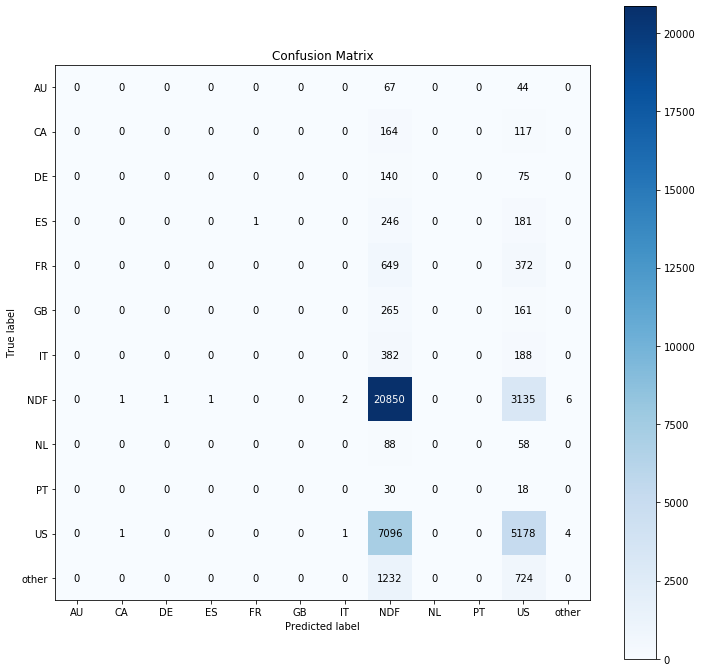

In [40]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

# Performance
nn_performance = {'model': 'Neural Network Model', 
                  'acc': acc_nn, 
                  'balanced_acc': balanced_acc_nn, 
                  'kappa_score': kappa_nn}

### 7.2.2. Neural Network - Performance - Cross-Validation

In [41]:
# cross validation peformance
acc_nn, balanced_acc_nn, kappa_nn = cross_validation(num_fold=5, 
                                                     x_train=x_train, 
                                                     y_train=y_train, 
                                                     model=model_nn,
                                                     verbose=True)

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [42]:
# Performance
nn_performance_cv = {'model': 'Neural Network Model - CV', 
                     'acc': f'{np.round(np.mean(acc_nn), 2)} +/- {np.round(np.std(acc_nn),4)}', 
                     'balanced_acc': f'{np.round(np.mean(balanced_acc_nn), 2)} +/- {np.round(np.std(balanced_acc_nn),4)}', 
                     'kappa_score': f'{np.round(np.mean(kappa_nn), 2)} +/- {np.round(np.std(kappa_nn), 4)}'}

In [43]:
print(f'Avg Accuracy: {np.round(np.mean(acc_nn), 2)} +/- {np.round(np.std(acc_nn),4)}')
print(f'Avg Balanced Accuracy: {np.round(np.mean(balanced_acc_nn), 2)} +/- {np.round(np.std(balanced_acc_nn),4)}')
print(f'Avg Kappa Score: {np.round(np.mean(kappa_nn), 2)} +/- {np.round(np.std(kappa_nn), 4)}')

Avg Accuracy: 0.62 +/- 0.0009
Avg Balanced Accuracy: 0.11 +/- 0.001
Avg Kappa Score: 0.22 +/- 0.0071


# 8.0. Hyper Parameter Tuning

Hyper Parameter Tuning will not be considered until the most optimal machine learning model is selected, at this first cycle was considered only one model to complete the cycle and go through for all the major phases to validate the feasibility of the project.

# 9.0. Error Translation and Interpretation

# 10.0. Deploy Model

No models will be deployed yet.

# 11.0. Conclusion

Through the replacement of the null values (NA), excluded in the first cycle, it was possible to return to the dataset more than 50% of the data along with an integer class (NDF), which coincidentally is the marjority class, increasing the complexity of the project.

Cross-validation allowed us to evaluate the model with greater reliability by using different fractions of the data for validate and test the performance, measuring its efficiency for different periods of time.

## 11.1. Current Cycle Performance

In [44]:
# performance dataframe
df_performance = pd.DataFrame([baseline_performance, nn_performance, nn_performance_cv])
df_performance['cycle'] = '3rd_cycle'
df_performance['process'] = 'replace_na'
df_performance = df_performance[['cycle', 'process', 'model', 'acc', 'balanced_acc', 'kappa_score']]

# save 3rd cycle to comparison
df_performance.to_csv('../Datasets/3rd_cycle_performance', index=False)

# display performance dataframe
df_performance

,cycle,process,model,acc,balanced_acc,kappa_score
0,3rd_cycle,replace_na,Baseline Model,0.42543,0.082245,0.00081
1,3rd_cycle,replace_na,Neural Network Model,0.627513,0.107546,0.242178
2,3rd_cycle,replace_na,Neural Network Model - CV,0.62 +/- 0.0009,0.11 +/- 0.001,0.22 +/- 0.0071


## 11.2. Cycle Comparison

In [49]:
# first cycle performance load
performance_1st_cycle = pd.read_csv('../Datasets/1st_cycle_performance')

# second cycle performance load
performance_2nd_cycle = pd.read_csv('../Datasets/2nd_cycle_performance')

# join cycles dataframes
performance = pd.concat([performance_1st_cycle, 
                         performance_2nd_cycle, 
                         df_performance]).reset_index(drop=True)

# filter baseline model
performance = performance[(performance['model'] != 'Baseline Model') & 
                          (performance['model'] != 'Neural Network Model - CV')].fillna(0)

# display performance
performance

,cycle,process,model,acc,balanced_acc,kappa_score
0,1st_cycle,validation_pipeline,Neural Network Model,0.703484,0.000000,0.000000
2,2nd_cycle,baseline_model,Neural Network Model,0.702970,0.091973,0.002400
4,3rd_cycle,replace_na,Neural Network Model,0.627513,0.107546,0.242178


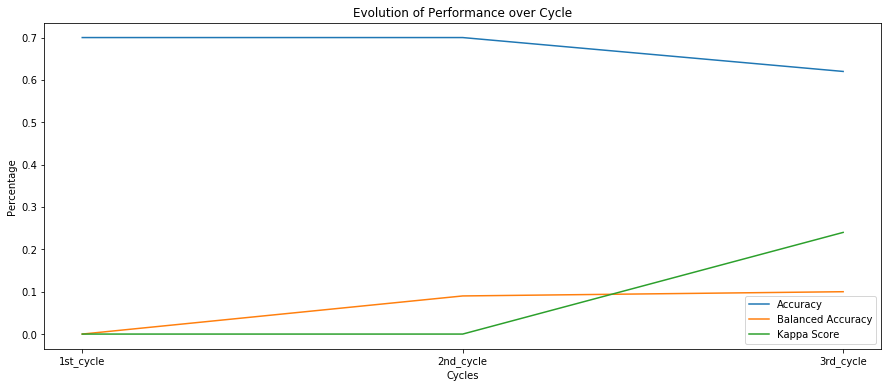

In [50]:
plt.figure(figsize=(15,6))

# formated metrics
performance['acc'] = performance['acc'].apply(lambda x: str(x)[0:4]).astype(float)

performance['balanced_acc'] = performance['balanced_acc'].apply(lambda x: str(x)[0:4]).astype(float)

performance['kappa_score'] = performance['kappa_score'].apply(lambda x: str(x)[0:4]).astype(float)

# Evolution of Performance over Cycles
sns.lineplot(x='cycle', y='acc', data=performance)

sns.lineplot(x='cycle', y='balanced_acc', data=performance)

sns.lineplot(x='cycle', y='kappa_score', data=performance)

# set legend and titles
plt.legend(labels=['Accuracy','Balanced Accuracy', 'Kappa Score'])
plt.title('Evolution of Performance over Cycle')
plt.ylabel('Percentage')
plt.xlabel('Cycles');